In [1]:
from utils import kappa, ode_system, fs8, chi_squared

In [2]:
import numpy as np

from getdist import plots, MCSamples

from scipy.optimize import minimize
from scipy.integrate import solve_ivp


import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


In [3]:
om_fdl = [0.3, 0.3, 0.266, 0.3, 0.31, 0.3, 0.27, 0.27, 0.25, 0.25,
          0.274,0.307115, 0.27, 0.27, 0.27, 0.3, 0.3, 0.27]

file_path = 'data/Cij_WiggleZ.txt'
Wiggle = np.loadtxt(file_path)

data_file_path = 'data/data_growth_2016_main.txt'
data = np.loadtxt(data_file_path)

In [6]:
z_data = data[:,0]
y_data = data[:,1]
sigma = data[:,2]

cov = np.eye(len(z_data))

# Replace the diagonal of the identity matrix with the array elements
np.fill_diagonal(cov, sigma**2)
cov[12:15, 12:15] = Wiggle
cov_inv = np.linalg.inv(cov)

a_data = 1/(z_data+1)

a_data = a_data[::-1]
y_data = y_data[::-1]
sigma  = sigma[::-1]
om_fdl = om_fdl[::-1]

In [8]:
ai,af,da = 1e-3,1, 1e-4
yi,xi = ai,1
N = int(round((af-ai)/da))
a_values = np.linspace(ai, af, N)
indices = np.searchsorted(a_values, a_data, side="left")
a_values[indices] = a_data
initial_conditions = [yi, xi]

In [14]:
samples = np.load('samples_GCDM.npz')['arr_0']

samples_plt = MCSamples(samples=samples,names=['b','sig'], labels=[r'\Omega_m', r'\sigma_8'])

p = samples_plt.getParams()
samples_plt.addDerived(1/kappa(1, 0, p.b), name='Om', label=r'\Omega_m')

Removed no burn in


In [15]:
samples_plt.mean(samples_plt.samples)

array([0.24360032, 0.87309789, 0.28169993])

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$\Omega_m       $} & $0.244^{+0.087}_{-0.097}   $\\

{\boldmath$\sigma_8       $} & $0.87^{+0.20}_{-0.19}      $\\

$\Omega_m                  $ & $0.282^{+0.089}_{-0.071}   $\\
\hline
\end{tabular}
chi^2: 14.237476484597448


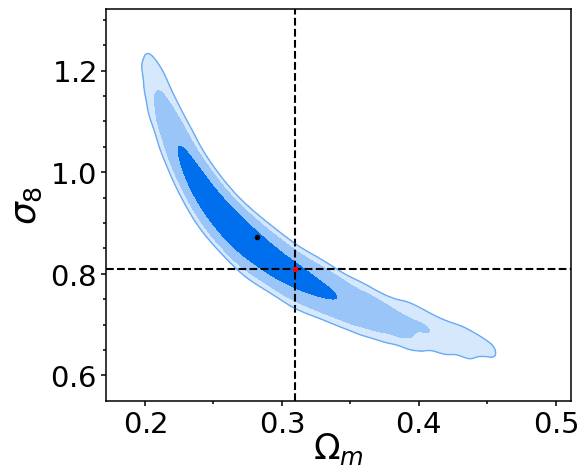

In [20]:
Om_planck,    sig_planck = 0.31,  0.81
Om_lcdm,      sig_lcdm   = 0.22,  0.89  #obtained by fitting the LCDM model which corresponds to setting b = 0
b_gcdm,       sig_gcdm,     Om_gcdm  = samples_plt.mean(samples_plt.samples)

g = plots.get_single_plotter(width_inch=6, ratio=1/1.18, rc_sizes=20)
g.settings.num_plot_contours = 3

plt.axvline(x=Om_planck, color='k', linestyle='--')
plt.axhline(y=sig_planck, color='k', linestyle='--')

g.plot_2d([samples_plt], ('Om','sig'),filled=True)

ax = g.subplots[0][0]

plt.gca().yaxis.set_minor_locator(mticker.MultipleLocator(0.05))
plt.gca().xaxis.set_minor_locator(mticker.MultipleLocator(0.05))

ax.tick_params(axis='both', which='both', width=1.1, labelsize=21, labelcolor='black')

ax.set_xlabel(r'$\Omega_m$', fontsize=25, fontweight='bold')
ax.set_ylabel(r'$\sigma_8$', fontsize=26, fontweight='bold')

plt.plot([Om_planck], [sig_planck], '.', color= 'red')
plt.plot([Om_gcdm], [sig_gcdm], '.', color= 'black')

for spine in ax.spines.values():
    spine.set_linewidth(1.1)

g.export('figures/GCDM_confidence.png')

print(samples_plt.getTable().tableTex())

final_loss = chi_squared([b_gcdm,sig_gcdm], fs8, a_values, a_data, y_data, cov_inv, om_fdl)
print("chi^2:", final_loss)

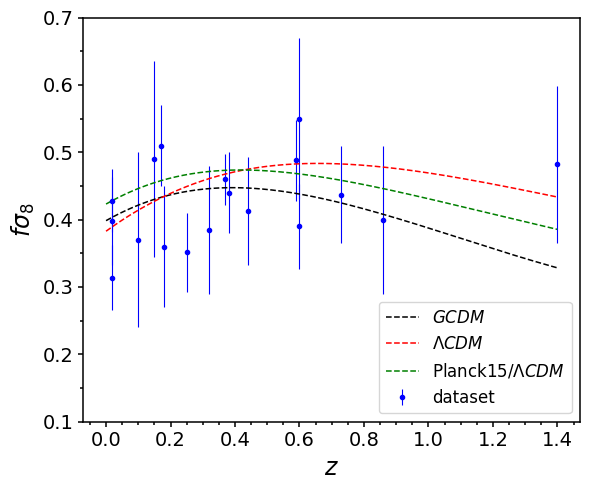

In [21]:
k = 300
sol1 = solve_ivp(ode_system, [ai, af], initial_conditions, args=(0, b_gcdm, k), t_eval=a_values)
sol2 = solve_ivp(ode_system, [ai, af], initial_conditions, args=(1/Om_planck -1, 0, 0), t_eval=a_values)
sol3 = solve_ivp(ode_system, [ai, af], initial_conditions, args=(1/Om_lcdm - 1, 0, 0), t_eval=a_values)

G_delta, G_delta_prime = sol1.y
PL_delta, PL_delta_prime = sol2.y
L_delta, L_delta_prime = sol3.y


G_pred        =  fs8(G_delta,  sig_gcdm,  G_delta_prime, a_values)
PL_pred       =  fs8(PL_delta, sig_planck, PL_delta_prime, a_values)
L_pred        =  fs8(L_delta,  sig_lcdm, L_delta_prime, a_values)


z_data  = data[:,0]
y_data  = data[:,1]
sigma   = data[:,2]

z = 1/a_values - 1

z14indx = np.where(z[::-1] == 1.4)[0][0]

plt.figure(figsize=(6,5))
plt.errorbar(z_data, y_data, sigma, fmt='.', color='b',     label = "dataset", linewidth=0.8)
plt.plot(z[::-1][:z14indx], G_pred[::-1][:z14indx],    'k--', label = "$GCDM$", linewidth=1.1)
plt.plot(z[::-1][:z14indx], L_pred[::-1][:z14indx],    'r--',      label = r"$\Lambda CDM$", linewidth=1.1)
plt.plot(z[::-1][:z14indx], PL_pred[::-1][:z14indx],   'g--',      label = r"Planck15/$\Lambda CDM$", linewidth=1.1)
plt.legend(fontsize=12,loc='lower right')
plt.xlabel(r'$z$',size = 17, fontweight='bold')
plt.ylabel(r'$f\sigma_8$',size = 17, fontweight='bold')

plt.gca().yaxis.set_minor_locator(mticker.MultipleLocator(0.05))
plt.gca().xaxis.set_minor_locator(mticker.MultipleLocator(0.05))

plt.gca().tick_params(axis='both', which='both', width=1.1, labelsize=14, labelcolor='black')

for spine in plt.gca().spines.values():
    spine.set_linewidth(1.1)

plt.ylim(0.1,0.7)
plt.tight_layout()

plt.savefig('figures/fsigma8.png')

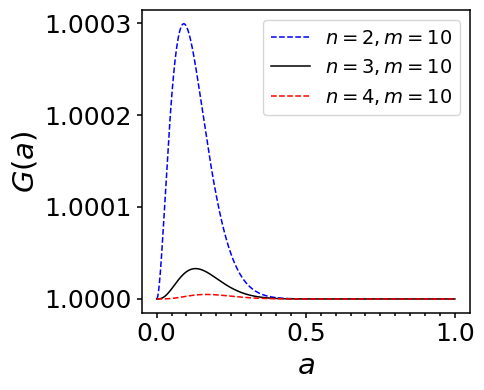

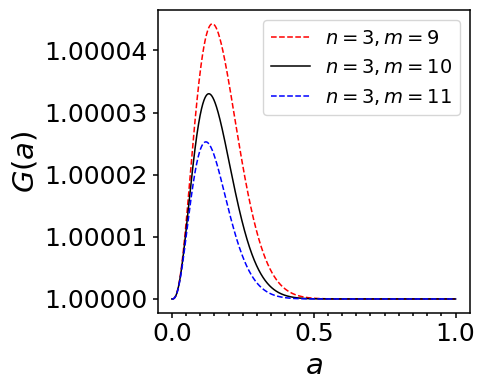

In [22]:

ai,af,da = 1e-4,1, 1e-4
N = int(round((af-ai)/da))
a_values = np.linspace(ai, af, N)

def G1(a, b1,n,m):
  return 1 + b1  * a**n *  (1-a)**(2*m)


plt.figure(figsize=(5,4))
plt.plot(a_values, G1(a_values,b_gcdm,2,10),    'b--',  label = "$n=2,m=10$", linewidth=1.1)
plt.plot(a_values, G1(a_values,b_gcdm,3,10),    'k',  label = "$n=3,m=10$", linewidth=1.1)
plt.plot(a_values, G1(a_values,b_gcdm,4,10),    'r--',  label = "$n=4,m=10$", linewidth=1.1)

plt.legend(fontsize=14)
plt.xlabel(r'$a$',size = 21, fontweight='bold')
plt.ylabel(r'$G(a)$',size = 21, fontweight='bold')

plt.gca().yaxis.set_minor_locator(mticker.MultipleLocator(0.05))
plt.gca().xaxis.set_minor_locator(mticker.MultipleLocator(0.05))

plt.gca().tick_params(axis='both', which='both', width=1.1, labelsize=18, labelcolor='black')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))

plt.tight_layout()

for spine in plt.gca().spines.values():
    spine.set_linewidth(1.1)

plt.savefig('figures/Gn.png')




plt.figure(figsize=(5,4))
plt.plot(a_values, G1(a_values,b_gcdm,3,9),    'r--',  label = "$n=3,m=9$", linewidth=1.1)
plt.plot(a_values, G1(a_values,b_gcdm,3,10),    'k',  label = "$n=3,m=10$", linewidth=1.1)
plt.plot(a_values, G1(a_values,b_gcdm,3,11),    'b--',  label = "$n=3,m=11$", linewidth=1.1)
plt.legend(fontsize=14)
plt.xlabel(r'$a$',size = 21, fontweight='bold')
plt.ylabel(r'$G(a)$',size = 21, fontweight='bold')

plt.gca().yaxis.set_minor_locator(mticker.MultipleLocator(0.05))
plt.gca().xaxis.set_minor_locator(mticker.MultipleLocator(0.05))

plt.gca().tick_params(axis='both', which='both', width=1.1, labelsize=18, labelcolor='black')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.5f'))

plt.tight_layout()

for spine in plt.gca().spines.values():
    spine.set_linewidth(1.1)

plt.savefig('figures/Gm.png')

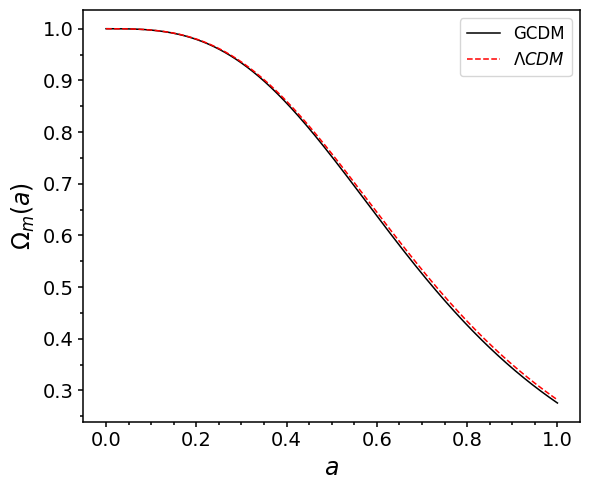

In [25]:

plt.figure(figsize = (6,5))
plt.plot(a_values, 1/kappa(a_values,  0,         b_gcdm),    'k',  label = "GCDM", linewidth=1.1)
plt.plot(a_values, 1/kappa(a_values,  1/Om_gcdm-1,  0),        'r--',    label = "$\Lambda CDM$", linewidth=1.1)
plt.legend(fontsize=12)
plt.xlabel(r'$a$',size = 17, fontweight='bold')
plt.ylabel(r'$\Omega_m(a)$',size = 17, fontweight='bold')

plt.gca().yaxis.set_minor_locator(mticker.MultipleLocator(0.05))
plt.gca().xaxis.set_minor_locator(mticker.MultipleLocator(0.05))

plt.gca().tick_params(axis='both', which='both', width=1.1, labelsize=14, labelcolor='black')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

plt.tight_layout()

for spine in plt.gca().spines.values():
    spine.set_linewidth(1.1)

plt.savefig('figures/Om_m.png')